In [ ]:
#best fit Elliott

In [1]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from numpy import genfromtxt

In [2]:
h = 6.62606957 * 10 ** (-34)
c0 = 299792458
charge = 1.602176565 * 10 ** (-19)
thickness = 1 * 10 ** (-5)


In [3]:
#make a bunch of useful functions
def zero_remover(data):  #Only for lists
    zero_removed_data = []
    for i in range(0, len(data)):
        if data[i] > 0:
            zero_removed_data.append(data[i])
        else:
            zero_removed_data.append(0)
    zero_removed_data = np.array(zero_removed_data)
    return zero_removed_data

def csv_to_numpy(csv_file):
    all_data = genfromtxt(csv_file, delimiter=",", dtype=float, missing_values=["NaN", "#DIV/0!"], filling_values=0)
    all_data_removed_headers = all_data[2:, :]
    cleaned_data = np.where(all_data_removed_headers > 0, all_data_removed_headers, 0)
    return cleaned_data

def seperated_data(clean_data):
    wavelength = np.array(clean_data[:, 0])
    transmission0 = np.array(clean_data[:, 1])
    transmission100 = np.array(clean_data[:, 2])
    BA2PbI4 = np.array(clean_data[:, 3])
    SC_BA2MAPb2I7 = np.array(clean_data[:, 4])
    PC_BA2MAPb2I7 = np.array(clean_data[:, 5])

    energy_J = h * c0 / (wavelength * (10 ** (-9)))
    energy_eV = energy_J / charge
    incident = transmission100 - transmission0
    BA2PbI4_background = BA2PbI4 - transmission0
    SC_BA2MAPb2I7_background = SC_BA2MAPb2I7 - transmission0
    PC_BA2MAPb2I7_background = PC_BA2MAPb2I7 - transmission0
    return energy_eV, wavelength, incident, BA2PbI4_background, SC_BA2MAPb2I7_background, PC_BA2MAPb2I7_background

def all_calcs(incident, material):
    tranmission_material = (material / incident) * 100  #is this absorpTance & visa versa?
    absorbance = np.log10(incident / material)
    coefficient_literature = (np.log(10) / thickness) * absorbance
    return tranmission_material, absorbance, coefficient_literature

def format_sig_fig(x, sig_fig):
    """
    Format a number x to sig_fig significant figures,
    preserving trailing zeros as decimal places when needed.
    """
    if x == 0:
        return f"{0:.{sig_fig}f}"  # just return 0.00... for consistency
    # Determine how many digits before decimal
    import math
    digits_before_decimal = int(math.floor(math.log10(abs(x)))) + 1
    decimals_needed = max(sig_fig - digits_before_decimal, 0)
    return f"{x:.{decimals_needed}f}"

In [4]:
#Load in the data
directory = r"A:\Y4 Project code\Data\Raw data"
# Use glob to find all CSV files (recursively if needed)
csv_files = glob.glob(os.path.join(directory, "*.csv"))

data_dict = {}

for file in csv_files:
    key = os.path.splitext(os.path.basename(file))[0]
    #print(key)
    key = key.replace("Easy access data - ", "",
                      1)  #format == key.replace("old bit of key", "new bit of key", "counts(if counts == 1 then replaces all instances)")
    #print(key)
    short_key = key.split(" - ")[0].strip()
    short_key = short_key.split(" -")[0].strip()
    short_key = short_key.split("-")[0].strip()  # remove everything after the "-" in the item called "short_key"

    short_key = short_key.replace("m", "", 1)
    short_key = short_key.replace(" heat", "", 1)

    hours = int(short_key.split("h")[0].strip())
    #print(hours, "hours")
    minutes = int(short_key.split("h")[1].strip()) if len(short_key) > 1 and short_key.split("h")[1].strip() else 0
    #print(minutes, "minutes")
    if minutes > 30:
        hours = hours + 1

    #print(short_key)
    #print(key)
    data_dict[str(hours)] = csv_to_numpy(file)
print(data_dict.keys())
#print(data_dict["0"][:, 0])
#print(data_dict["0"][:, 1])
#print(data_dict["0"][:, 2])
#print(data_dict["0"][:, 3])
#print(data_dict["0"][:, 4])
#print(data_dict["0"][:, 5])

#the order of the keys is in the awful ['0', '139', '162', '167', '185', '192', '1', '209', '21', '215', '26', '44', '50', '67', '73'] order. We need to fix that
key_list = []
for key in data_dict.keys():
    key_list.append(int(key))
    correct_key_order = np.argsort(key_list)
print(correct_key_order)

correct_keys = []

for key in correct_key_order:
    correct_keys.append(key_list[key])

new_dict = {}

for key in correct_keys:
    new_dict[str(key)] = data_dict[str(key)]
data_dict = new_dict
print(data_dict.keys())  #viola!

dict_keys(['0', '139', '162', '167', '185', '192', '1', '209', '21', '215', '26', '44', '50', '67', '73'])
[ 0  6  8 10 11 12 13 14  1  2  3  4  5  7  9]
dict_keys(['0', '1', '21', '26', '44', '50', '67', '73', '139', '162', '167', '185', '192', '209', '215'])


In [5]:
data = data_dict["0"]
#print(data.shape)
energy_eV, wavelength, incident, BA2PbI4_background, SC_BA2MAPb2I7_background, PC_BA2MAPb2I7_background = seperated_data(data)

trans, absorb, absco = all_calcs(incident, PC_BA2MAPb2I7_background)
x = energy_eV
#print(x.shape)
y = absco
#print(y.shape)

for i in range(len(x)):
    value = x[i]
    if np.isnan(value):
        x[i] = 0.0
for i in range(len(y)):
    value = y[i]
    if np.isnan(value) or not np.isfinite(value):
        y[i] = 0.0
print(energy_eV)

#make the data better
start = h * c0 /(800 * charge* 10**-9)
end = h * c0 /(450 * charge* 10**-9)

mask = (x >= start) & (x <= end)
x = x[mask]
y = y[mask]/(1e5)
print(y)

[6.59743055 6.58072731 6.56410843 ... 1.1213145  1.12088063 1.12044709]
[4.44903893 4.61327224 4.57201274 4.8408662  5.16592927 4.75722153
 4.98786947 5.1617066  4.96601694 4.96877314 4.24471166 5.17437101
 5.13039983 4.59746074 4.46842994 4.93934171 4.56144959 3.86749124
 4.47119001 4.41716476 4.99938244 4.48241738 4.80756073 4.29478574
 4.76850736 4.4178893  5.33309191 4.15630878 4.19381064 4.45395949
 4.61836614 4.10235004 4.75262667 4.6263762  4.33734519 4.0772448
 4.5028072  4.35751771 4.38214094 4.36893634 4.49852243 4.32364605
 4.20577906 4.49537468 4.41296124 4.27048076 4.60531811 4.33838302
 4.4983452  4.24104258 4.4793198  4.28363846 4.26639997 4.30847485
 4.45742534 4.38292969 4.50958965 4.38008773 4.43881795 4.30776996
 3.9207408  4.25261244 4.3238758  4.15731455 4.43201379 4.46342602
 4.20291829 4.64267996 4.32175612 4.36127076 4.40133716 4.37432791
 4.263622   4.39304691 4.17909439 4.13171093 4.02595548 4.44925589
 4.19704124 4.27876291 4.31498258 4.21715719 4.19410882 4.

C:\Users\user\AppData\Local\Temp\ipykernel_2180\1100359985.py:35: RuntimeWarning: divide by zero encountered in divide
  tranmission_material = (material / incident) * 100  #is this absorpTance & visa versa?
C:\Users\user\AppData\Local\Temp\ipykernel_2180\1100359985.py:35: RuntimeWarning: invalid value encountered in divide
  tranmission_material = (material / incident) * 100  #is this absorpTance & visa versa?
C:\Users\user\AppData\Local\Temp\ipykernel_2180\1100359985.py:36: RuntimeWarning: divide by zero encountered in divide
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_2180\1100359985.py:36: RuntimeWarning: invalid value encountered in divide
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_2180\1100359985.py:36: RuntimeWarning: divide by zero encountered in log10
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_2180\1100359985.py:36: RuntimeWarning: invalid value

C:\Users\user\AppData\Local\Temp\ipykernel_2180\2890992278.py:23: RuntimeWarning: invalid value encountered in sqrt
  wierd_bit = 2 * np.pi * np.sqrt(E_B/(delta[safe]))
C:\Users\user\AppData\Local\Temp\ipykernel_2180\2890992278.py:75: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(model, x, y, maxfev=100000)


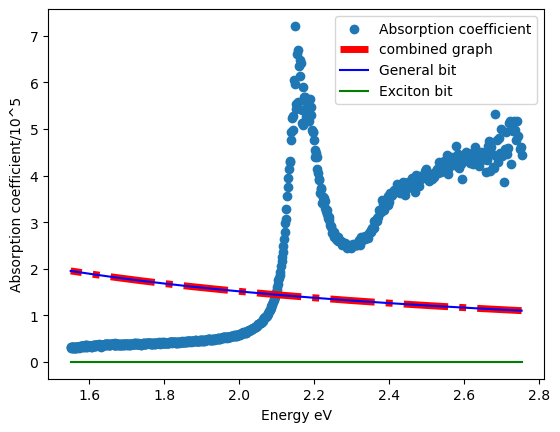

A = 0.8157 ± inf
E_G = 5.3382 ± inf
E_B = 0.3493 ± inf


In [7]:
def model(x, A, E_G, E_B):#, test):
    def dirac_delta_gaussian(x, x0, sigma):
        return np.exp(-(x-x0)**2/(2*sigma**2))

    standard_deviation = 0.0001
    first_bit = A/ np.where(x == 0, np.inf, x)
    #first_bit = A

    whole_summation_term = np.zeros_like(x, dtype=float)
    for n in range(1, 1):
        summation_bit_pre_dirac_delta = (4* np.pi * (E_B**(3/2)))/(n**3)

        centre = E_G - (E_B/(n**2))
        dirac_delta = dirac_delta_gaussian(x, centre, standard_deviation)

        summation_term = summation_bit_pre_dirac_delta * dirac_delta

        whole_summation_term += summation_term

    delta = np.maximum(x - E_G, 1e-6)
    bit_pre_JDoS = np.zeros_like(x)
    safe = delta > 0
    wierd_bit = 2 * np.pi * np.sqrt(E_B/(delta[safe]))
    bit_pre_JDoS[safe] = wierd_bit / (1-np.exp(-wierd_bit))

    #JDoS bit
    JDoS = np.zeros_like(x)
    JDoS[safe] = np.sqrt(delta[safe])
    JDoS_term = JDoS * bit_pre_JDoS
    #JDoS_term = JDoS * bit_pre_JDoS/(1-test*(x-E_G))

    return first_bit * (whole_summation_term + JDoS_term)

def the_exiton_bit(x, A, E_G, E_B):
    def dirac_delta_gaussian(x, x0, sigma):
        return np.exp(-(x-x0)**2/(2*sigma**2))

    standard_deviation = 0.0001
    first_bit = A/ np.where(x == 0, np.inf, x)
    #first_bit = A

    whole_summation_term = np.zeros_like(x, dtype=float)
    for n in range(1, 1000):
        summation_bit_pre_dirac_delta = (4* np.pi * (E_B**(3/2)))/(n**3)

        centre = E_G - (E_B/(n**2))
        dirac_delta = dirac_delta_gaussian(x, centre, standard_deviation)

        summation_term = summation_bit_pre_dirac_delta * dirac_delta

        whole_summation_term += summation_term
    return whole_summation_term * first_bit

def general_bit(x, A, E_G, E_B):
    def dirac_delta_gaussian(x, x0, sigma):
        return np.exp(-(x-x0)**2/(2*sigma**2))

    standard_deviation = 0.0001
    first_bit = A/ np.where(x == 0, np.inf, x)
    #first_bit = A

    delta = np.maximum(x - E_G, 1e-6)
    bit_pre_JDoS = np.zeros_like(x)
    safe = delta > 0
    wierd_bit = 2 * np.pi * np.sqrt(E_B/(delta[safe]))
    bit_pre_JDoS[safe] = wierd_bit / (1-np.exp(-wierd_bit))

    #JDoS bit
    JDoS = np.zeros_like(x)
    JDoS[safe] = np.sqrt(delta[safe])
    JDoS_term = JDoS * bit_pre_JDoS
    #JDoS_term = JDoS * bit_pre_JDoS/(1-test*(x-E_G))
    return first_bit * JDoS_term

params, covariance = curve_fit(model, x, y, maxfev=100000)
# your initial guesses
A0 = 1
EG0 = 2.4
EB0 = 50e-3
test=0

#p0 = [A0, EG0, EB0, test]
p0 = [A0, EG0, EB0]

# Uncertainties (1σ standard deviations)
#(A_err, E_G_err, E_B_err, test_err) = np.sqrt(np.diag(covariance))
#A, E_G, E_B, test = params
(A_err, E_G_err, E_B_err) = np.sqrt(np.diag(covariance))
A, E_G, E_B= params

plt.scatter(x, y)
plt.plot(x, model(x, *params), color='red', linestyle='-.', linewidth=5)
plt.plot(x, general_bit(x, *params), color='blue')
plt.plot(x, the_exiton_bit(x, *params), color='green')
plt.legend(['Absorption coefficient', "combined graph",'General bit', 'Exciton bit'])
plt.ylabel('Absorption coefficient/10^5')
plt.xlabel('Energy eV')
plt.show()

print(f"A = {A:.4f} ± {A_err:.4f}")
print(f"E_G = {E_G:.4f} ± {E_G_err:.4f}")
print(f"E_B = {E_B:.4f} ± {E_B_err:.4f}")
#print(f"test = {test:.4f} ± {test_err:.4f}")

In [ ]:
#\alpha(E, E_g, E_b)= \frac{b_{0}}{E} \sum_{n=1}^{\infty}{\frac{4\pi E_{B}^{\frac{3}{2}}}{n^{3}}\delta(E - (E_g - \frac{E_b}{n^2}))}+ \frac{b_{0}}{E}\frac{2\pi \sqrt{\frac{E_{b}}{E-E_{g}}}}{1-e^{-2\pi \sqrt{\frac{E_{b}}{E-E_{g}}}}}\sqrt{E-E_{g}}
